In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mylibrary.nnlib as tnn
import mylibrary.datasets as datasets
import copy
%matplotlib inline

## Loading the dataset

In [2]:
mnist = datasets.MNIST()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

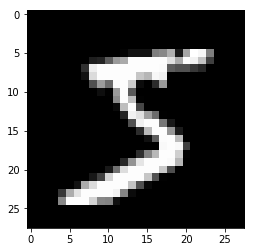

In [3]:
plt.imshow(train_data[0].reshape(28,28), cmap='gray')

In [4]:
input_size = 784
output_size = 10

learning_rate = 0.0001
batch_size = 64#300
EPOCHS = 10

train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label)

## Training a linear model

In [5]:
# linear_regression = tnn.LinearLayer(input_size, output_size, optimizer=tnn.Adam())

# accuracy_list = []
# for epoch in range(EPOCHS):
#     for index in range(train_size // batch_size):
#         train_x = train_data[index * batch_size:(index + 1) * batch_size]
#         train_y = train_label[index * batch_size:(index + 1) * batch_size]
        
#         yout = linear_regression.forward(train_x)

#         dy = tnn.SoftmaxCrossEntropy.del_loss(yout, train_y)
#         loss = tnn.SoftmaxCrossEntropy.loss(yout, train_y)

#         dx = linear_regression.backward(dy)

#         linear_regression.update()
        
#         if index % 100 == 0:
            
#             print('\nTRAIN',index, '-> ', loss)
#             yout = linear_regression.forward(train_data)
#             outputs = tnn.Logits.logit_to_index(yout)
#             correct = (outputs == np.array(train_label_)).sum()

#             accuracy = correct / len(train_label_) * 100.
#             print('EPOCH = ',epoch,'accuracy = ', accuracy)
#             print(correct, '/', len(train_label_))
            
#             yout = linear_regression.forward(test_data)
#             outputs = tnn.Logits.logit_to_index(yout)
#             correct = (outputs == np.array(test_label_)).sum()

#             accuracy = correct / len(test_label_) * 100.
#             print('   TEST  ','accuracy = ', accuracy)
#             print(correct, '/', len(test_label_))            

## Creating a Soft Decision Tree classes

In [25]:
class LeafNode(object):
    
    def __init__(self, input_dim, output_dim, learning_rate=0.0001):
        self.fc = tnn.LinearLayer(input_dim, output_dim, optimizer=tnn.Adam(learning_rate))
        self.prob = None
        self.del_outputs = None
        self.del_prob = None
        
    def forward(self, inputs):
        fc_out = self.fc.forward(inputs)
        return fc_out
    
    def backward(self, del_outputs):
        self.del_outputs = del_outputs
        del_inputs = self.fc.backward(del_outputs)
        return del_inputs
    
    def update(self):
        self.fc.update()
        

class InnerNode(object):
    
    def __init__(self, input_dim, output_dim, learning_rate=0.0001):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        self.fc = tnn.NonLinearLayer(input_dim, 1, activation=tnn.Tanh(), optimizer=tnn.Adam(learning_rate))
        self.bias = tnn.BiasLayer(output_dim, optimizer=tnn.Adam(learning_rate))
        self.left = None
        self.right = None

        self.probs = None
        
        self.mask_left = None
        self.mask_right = None
        self.scaler_left = None
        self.scaler_right = None
        
        self.out_left = None
        self.out_right = None
        return
    
    def create_child(self, depth):
        if depth > 1:
            self.left = InnerNode(self.input_dim, self.output_dim, self.learning_rate)
            self.right = InnerNode(self.input_dim, self.output_dim, self.learning_rate)
            self.left.create_child(depth-1)
            self.right.create_child(depth-1)
        else:
            self.left = LeafNode(self.input_dim, self.output_dim, self.learning_rate)
            self.right = LeafNode(self.input_dim, self.output_dim, self.learning_rate)

    
    def forward(self, inputs):
        self.probs = self.fc.forward(inputs)
        
        self.mask_left = self.probs>=0
        self.mask_right = ~self.mask_left
        self.scaler_left = self.probs*self.mask_left
        self.scaler_right = -self.probs*self.mask_right
        
        self.out_left = self.left.forward(inputs)
        self.out_right = self.right.forward(inputs)
        
        output = self.out_left*self.scaler_left + self.out_right*self.scaler_right
        outputs = self.bias.forward(output)
        return outputs
        
#         self.probs = self.fc.forward(inputs)
#         self.prob_left = self.probs
#         self.prob_right = (1-self.probs)        
        
#         self.out_left = self.left.forward(inputs)
#         self.out_right = self.right.forward(inputs)
        
#         output = self.out_left*self.prob_left + self.out_right*self.prob_right
#         return output        
        
    
    def backward(self, del_outputs):
        del_outputs = self.bias.backward(del_outputs)
        
        del_out_left = del_outputs*self.scaler_left
        del_out_right = del_outputs*self.scaler_right
        
        del_inp_left = self.left.backward(del_out_left)
        del_inp_right = self.right.backward(del_out_right)
        
        del_scaler_left = np.mean(self.out_left*del_outputs, axis=1, keepdims=True)
        del_scaler_right = np.mean(self.out_right*del_outputs, axis=1, keepdims=True)
        
        del_probs = del_scaler_left*self.mask_left - del_scaler_right*self.mask_right
        del_inp_probs = self.fc.backward(del_probs)
        
        del_inputs = del_inp_left + del_inp_right + del_inp_probs
        
        return del_inputs
        
#         del_out_left = del_outputs*self.prob_left
#         del_out_right = del_outputs*self.prob_right

#         del_inp_left = self.left.backward(del_out_left)
#         del_inp_right = self.right.backward(del_out_right)
        
#         del_prob_left = np.mean(self.out_left*del_outputs, axis=1, keepdims=True)
#         del_prob_right = np.mean(self.out_right*del_outputs, axis=1, keepdims=True)
        
#         del_probs = (del_prob_left - del_prob_right)
#         del_inp_probs = self.fc.backward(del_probs)
        
#         del_inputs = del_inp_left + del_inp_right + del_inp_probs
        
#         return del_inputs
        
        
    def update(self):
        self.fc.update()
        self.bias.update()
        self.left.update()
        self.right.update()

In [26]:
sdt = InnerNode(input_size, output_size)
sdt.create_child(2)
sdt.left

In [27]:
target = train_label[:10]
output = sdt.forward(train_data[:10])
# np.argmax(output, axis=1)
# np.argmax(target, axis=1)
loss = tnn.SoftmaxCrossEntropy().loss(output, target)
del_outputs = tnn.SoftmaxCrossEntropy().del_loss(output, target)

del_input = sdt.backward(del_outputs)
sdt.update()

### doing this in a loop

In [36]:
tree_depth = 3
sdt = InnerNode(input_size, output_size, learning_rate=0.0003)
sdt.create_child(tree_depth)

EPOCHS = 20

In [37]:
accuracy_list = []
for epoch in range(EPOCHS):
    for index in range(train_size // batch_size):
        train_x = train_data[index * batch_size:(index + 1) * batch_size]
        train_y = train_label[index * batch_size:(index + 1) * batch_size]
        
        yout = sdt.forward(train_x)

        dy = tnn.SoftmaxCrossEntropy.del_loss(yout, train_y)
        loss = tnn.SoftmaxCrossEntropy.loss(yout, train_y)

        dx = sdt.backward(dy)

        sdt.update()
        
        if index % 100 == 0:
            
            print('\nTRAIN',index, '-> ', loss)
            yout = sdt.forward(train_data)
            outputs = tnn.Logits.logit_to_index(yout)
            correct = (outputs == np.array(train_label_)).sum()

            accuracy = correct / len(train_label_) * 100.
            print('EPOCH = ',epoch,'accuracy = ', accuracy)
            print(correct, '/', len(train_label_))
            
            yout = sdt.forward(test_data)
            outputs = tnn.Logits.logit_to_index(yout)
            correct = (outputs == np.array(test_label_)).sum()

            accuracy = correct / len(test_label_) * 100.
            print('   TEST  ','accuracy = ', accuracy)
            print(correct, '/', len(test_label_))            


TRAIN 0 ->  6.460959875932634
EPOCH =  0 accuracy =  14.155000000000001
8493 / 60000
   TEST   accuracy =  14.42
1442 / 10000

TRAIN 100 ->  6.23390568752186
EPOCH =  0 accuracy =  59.97833333333333
35987 / 60000
   TEST   accuracy =  60.25
6025 / 10000

TRAIN 200 ->  6.055095742635752
EPOCH =  0 accuracy =  78.32000000000001
46992 / 60000
   TEST   accuracy =  78.69
7869 / 10000

TRAIN 300 ->  5.892940989671791
EPOCH =  0 accuracy =  83.77
50262 / 60000
   TEST   accuracy =  84.77
8477 / 10000

TRAIN 400 ->  5.8611064940264646
EPOCH =  0 accuracy =  86.06666666666666
51640 / 60000
   TEST   accuracy =  87.01
8701 / 10000

TRAIN 500 ->  5.866803119375096
EPOCH =  0 accuracy =  86.77833333333334
52067 / 60000
   TEST   accuracy =  87.48
8748 / 10000

TRAIN 600 ->  5.884772069745599
EPOCH =  0 accuracy =  87.86333333333334
52718 / 60000
   TEST   accuracy =  88.63
8863 / 10000

TRAIN 700 ->  5.91198430034904
EPOCH =  0 accuracy =  88.42833333333333
53057 / 60000
   TEST   accuracy =  89


TRAIN 500 ->  5.794537594696811
EPOCH =  6 accuracy =  92.60333333333334
55562 / 60000
   TEST   accuracy =  92.47
9247 / 10000

TRAIN 600 ->  5.747203667047483
EPOCH =  6 accuracy =  92.515
55509 / 60000
   TEST   accuracy =  92.47
9247 / 10000

TRAIN 700 ->  5.813400749589141
EPOCH =  6 accuracy =  92.73
55638 / 60000
   TEST   accuracy =  92.49000000000001
9249 / 10000

TRAIN 800 ->  5.797865590732078
EPOCH =  6 accuracy =  92.715
55629 / 60000
   TEST   accuracy =  92.62
9262 / 10000

TRAIN 900 ->  5.812708623144878
EPOCH =  6 accuracy =  92.75333333333333
55652 / 60000
   TEST   accuracy =  92.58
9258 / 10000

TRAIN 0 ->  5.745959247912959
EPOCH =  7 accuracy =  92.53166666666667
55519 / 60000
   TEST   accuracy =  92.21000000000001
9221 / 10000

TRAIN 100 ->  5.753609103491057
EPOCH =  7 accuracy =  92.68166666666666
55609 / 60000
   TEST   accuracy =  92.28
9228 / 10000

TRAIN 200 ->  5.751959061518889
EPOCH =  7 accuracy =  92.58833333333332
55553 / 60000
   TEST   accuracy = 

EPOCH =  12 accuracy =  93.45166666666667
56071 / 60000
   TEST   accuracy =  92.80000000000001
9280 / 10000

TRAIN 900 ->  5.813395092250483
EPOCH =  12 accuracy =  93.47666666666666
56086 / 60000
   TEST   accuracy =  92.86999999999999
9287 / 10000

TRAIN 0 ->  5.722239082496304
EPOCH =  13 accuracy =  93.34
56004 / 60000
   TEST   accuracy =  92.64
9264 / 10000

TRAIN 100 ->  5.740919815970649
EPOCH =  13 accuracy =  93.47666666666666
56086 / 60000
   TEST   accuracy =  92.75999999999999
9276 / 10000

TRAIN 200 ->  5.74206719289018
EPOCH =  13 accuracy =  93.35
56010 / 60000
   TEST   accuracy =  92.66
9266 / 10000

TRAIN 300 ->  5.742987310108215
EPOCH =  13 accuracy =  93.55166666666666
56131 / 60000
   TEST   accuracy =  92.89
9289 / 10000

TRAIN 400 ->  5.765536712578081
EPOCH =  13 accuracy =  93.50833333333334
56105 / 60000
   TEST   accuracy =  92.83
9283 / 10000

TRAIN 500 ->  5.784525565012238
EPOCH =  13 accuracy =  93.48166666666667
56089 / 60000
   TEST   accuracy =  92.


TRAIN 200 ->  5.750014843586677
EPOCH =  19 accuracy =  93.73333333333333
56240 / 60000
   TEST   accuracy =  92.51
9251 / 10000

TRAIN 300 ->  5.740632779970813
EPOCH =  19 accuracy =  93.92833333333334
56357 / 60000
   TEST   accuracy =  92.99
9299 / 10000

TRAIN 400 ->  5.762093201195255
EPOCH =  19 accuracy =  93.84833333333333
56309 / 60000
   TEST   accuracy =  92.78
9278 / 10000

TRAIN 500 ->  5.778129850451153
EPOCH =  19 accuracy =  93.97833333333332
56387 / 60000
   TEST   accuracy =  93.01
9301 / 10000

TRAIN 600 ->  5.73686090745109
EPOCH =  19 accuracy =  93.88333333333333
56330 / 60000
   TEST   accuracy =  93.03
9303 / 10000

TRAIN 700 ->  5.770727152927597
EPOCH =  19 accuracy =  94.00333333333334
56402 / 60000
   TEST   accuracy =  92.92
9292 / 10000

TRAIN 800 ->  5.7829550224484425
EPOCH =  19 accuracy =  93.85833333333333
56315 / 60000
   TEST   accuracy =  93.02
9302 / 10000

TRAIN 900 ->  5.8183923133856315
EPOCH =  19 accuracy =  93.95333333333333
56372 / 60000


In [38]:
sdt.bias.bias

array([ 0.64583567,  0.05686194,  0.05635243,  0.03788388,  0.0417514 ,
        0.15181762,  0.11517363,  0.12327692, -0.01765835,  0.06158752])

In [39]:
sdt.left.bias.bias

array([-0.12205677, -0.01787538,  0.00242656, -0.02619485, -0.0172728 ,
        0.05202889,  0.00025393,  0.21340974, -0.01166403,  0.04492862])

In [40]:
sdt.left.left.bias.bias

array([-0.11148765, -0.03133655,  0.00300907, -0.03081681, -0.00888391,
        0.04657531, -0.00326854,  0.19687562, -0.01910116,  0.04087424])

In [43]:
sdt.left.left.left.fc.bias

array([-0.02762775, -0.01932783,  0.01114433, -0.02305181, -0.03839176,
        0.07051841,  0.0183783 ,  0.03402497, -0.01184968,  0.01865032])